# Feature Extraction and Unsupervised Learning with Tensorboard and t-SNE
This notebook extracts features from a directory of midi files using Music21's jSymbolic feature extractors. This is a compute-heavy task and can take between 10-30 seconds per midi file. Once extraction has been performed, the results can be cached (using pickle) and dimensionality reduction/visualization can be done using tensorboard's embedding projector.

## Imports

In [3]:
import time, os, csv, json, math, sys, operator
sys.path.append('../python')

import utils
import dill as pickle
import pandas as pd
from pprint import pprint
from multiprocessing import Pool as ThreadPool
import numpy as np
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
from sklearn.preprocessing import MinMaxScaler

## Extract Features
It is recommended to run this function sparingly and cache the results with pickle below to refrain from unecessary compute.

In [4]:
symlink_dir = '../../data/lmd_mono_tracks_seperated/'

num_threads = 8
pool = ThreadPool(num_threads)

start_time = time.time()
extracted_features = pool.map(utils.extract_features, [os.path.join(symlink_dir, n) for n in os.listdir(symlink_dir)][0:100])
print('Finished in {:.2f} seconds'.format(time.time() - start_time))

Finished in 80.04 seconds


In [6]:
extracted_features[0][1]

['Identifier',
 'Melodic_Interval_Histogram_0',
 'Melodic_Interval_Histogram_1',
 'Melodic_Interval_Histogram_2',
 'Melodic_Interval_Histogram_3',
 'Melodic_Interval_Histogram_4',
 'Melodic_Interval_Histogram_5',
 'Melodic_Interval_Histogram_6',
 'Melodic_Interval_Histogram_7',
 'Melodic_Interval_Histogram_8',
 'Melodic_Interval_Histogram_9',
 'Melodic_Interval_Histogram_10',
 'Melodic_Interval_Histogram_11',
 'Melodic_Interval_Histogram_12',
 'Melodic_Interval_Histogram_13',
 'Melodic_Interval_Histogram_14',
 'Melodic_Interval_Histogram_15',
 'Melodic_Interval_Histogram_16',
 'Melodic_Interval_Histogram_17',
 'Melodic_Interval_Histogram_18',
 'Melodic_Interval_Histogram_19',
 'Melodic_Interval_Histogram_20',
 'Melodic_Interval_Histogram_21',
 'Melodic_Interval_Histogram_22',
 'Melodic_Interval_Histogram_23',
 'Melodic_Interval_Histogram_24',
 'Melodic_Interval_Histogram_25',
 'Melodic_Interval_Histogram_26',
 'Melodic_Interval_Histogram_27',
 'Melodic_Interval_Histogram_28',
 'Melodic

## Save/Load cached feature extraction

In [2]:
## save cache
# with open('../../data/extracted_features/5000_midi_files_features.pickle', 'w') as f:
#     pickle.dump(extracted_features, f)

## load cache
with open('../../data/extracted_features/lmd_features.pickle', 'r') as f:
    extracted_features = pickle.load(f)

In [ ]:
# convert old feature extraction format
# for i, feat in enumerate(extracted_features):
#     if feat is not None:
#         assert(len(feat[0]) == 1)
#         extracted_features[i] = list(extracted_features[i]) # convert from immutable tuple
#         extracted_features[i][0] = extracted_features[i][0][0]

## Load MSD Cache

In [ ]:
start_time = time.time()
with open('../../data/msd.pickle', 'r') as f:
    msd = pickle.load(f)
print('Loaded in {:.2f} seconds'.format(time.time() - start_time))

## Tensorboard Labels/Metadata
Create a `metadata.tsv` file to assosciate msd track metadata to data points in tensorboard.

In [ ]:
LOG_DIR='../../data/embedding_logdir'
with open(os.path.expanduser('~') + '/Documents/code/midi-dataset/data/match_scores.json', 'r') as f:
    match_scores = json.load(f)

In [ ]:
def get_mid_to_track(match_scores):
    mid_to_track = {}
    for k, vals in match_scores.items():
        for v in vals:
            if not v in mid_to_track:
                mid_to_track[v] = {
                    'track': k,
                    'confidence': match_scores[k][v]
                }
            # if the new confidence score is higher than the last
            # update the track it points to
            elif match_scores[k][v] > mid_to_track[v]['confidence']:
                mid_to_track[v]['track'] = k
    return mid_to_track

def get_track_to_msd(msd):
    return { m['track_id']: m for m in msd }

def save_features_to_tsv(filename, features, mid_to_track, track_to_msd):
    with open(filename, 'w') as csvfile:
        
        fieldnames = ['path', 
                      'song_year',
                      'song_title',
                      'song_time_signature',
                      'song_tempo',
                      'song_key',
                      'song_mode',
                      'song_loudness',
                      'song_energy',
                      'song_duration',
                      'song_danceability',
                      'song_hotttnesss',
                      'artist_name',
                      'artist_terms',
                      'artist_mbtags',
                      'artist_hotttnesss',
                      'artist_location']

        writer = csv.DictWriter(csvfile, delimiter='\t', fieldnames=fieldnames)

        writer.writeheader()
        for f in extracted_features:
            if f is not None:
                path = f[1][-1]
                basename = os.path.basename(path)[0:-4]
                if basename in mid_to_track:
                    track = mid_to_track[basename]['track']
                    d = {k: v for k, v in track_to_msd[track].items() if k in fieldnames}
                    for k, v in d.items():
                        if isinstance(v, np.ndarray):
                            d[k] = v.tolist()[0] if len(v.tolist()) > 0 else ''#','.join(v.tolist())
                        try:
                            f = float(v)
                            if math.isnan(v):
                                d[k] = 0.0
                        except:
                            pass
                    writer.writerow(d)                     
                    
mid_to_track = utils.get_midi_to_track_lut() #get_mid_to_track(match_scores)
track_to_msd = get_track_to_msd(msd)
tsv = save_features_to_tsv(os.path.join(LOG_DIR, 'metadata.tsv'), extracted_features, mid_to_track, track_to_msd)

## Normalize
Don't do this... It decimates geometric relationships between features that is necessary for t-SNE.

In [ ]:
# feature-wize normalization between 0.0 and 1.0
def normalize_in_place(extracted_features):
    X = [x[0] for x in extracted_features if x is not None]
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)
    for i, x in enumerate(X):
        if extracted_features[i] is not None:
            extracted_features[i][0] = x

normalize_in_place(extracted_features)

## Analyze and remove unnecessary features
Clean up the results from the music21 feature extraction.

In [3]:
# remove the Identifier and Path key => value pairs from
# the extracted features
# WARNING: the Path is required to create the tensorboard
# embeddings metadata, so don't run this before creating
# those embeddings
for track in extracted_features:
    if track is not None:
        track[0].pop(0)
        track[0].pop(-1)
        track[1].pop(0)
        track[1].pop(-1)
        
utils.remove_weak_features(extracted_features, min_percent_of_tracks_with_feature=1.0)

Removed 154/299 features, or 0.52%. New feature size is 145.


In [4]:
embeddings = np.array([np.array(x[0], dtype=np.float64) for x in extracted_features if x is not None])

In [6]:
print(extracted_features[0])

[[0.6540779429489755, 0.03937324226597027, 0.14664523905182805, 0.06428284451586982, 0.028525512253917237, 0.022900763358778626, 0.0008035355564483728, 0.013258336681398152, 0.010847730012053034, 0.0008035355564483728, 0.0064282844515869825, 0.0, 0.01124949779027722, 0.0, 0.0, 0.0, 0.0, 0.0008035355564483728, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6540779429489755, 0.777822418642025, 0.6540779429489755, 0.03937324226597027, 0.09280835676978706, 0.013258336681398152, 0.0008035355564483728, 0.01124949779027722, 0.5265374894692502, 25.428571428571427, 12.375, 0.0, 0.0, 0.0, 0.0, 0.0006889424733034792, 0.0006889424733034792, 0.0006889424733034792, 0.0006889424733034792, 0.0, 0.006200482259731313, 0.07853944195659662, 0.23975198070961076, 0.07096107475025835, 0.005511539786427834, 0.21942817774715812, 0.0, 0.0006889424733034792, 0.0020668274199104374, 0.2035825008611781, 0.007578367206338271, 0.0, 0.011712022046159147, 0.01860144677919394, 0.0034447123665173962, 0.013434378229417844, 0.0

## Tensorboard Embeddings
Expose the embeddings to be used tensorboard.

In [ ]:
sess = tf.Session()
# create embeddings var
emb = tf.Variable(embeddings, name='embeddings')

# embedding projector
summary_writer = tf.train.SummaryWriter(LOG_DIR)
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = emb.name
embedding.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')
projector.visualize_embeddings(summary_writer, config)

# init and run the session
init = tf.global_variables_initializer()
sess.run(init)

# save checkpoint
saver = tf.train.Saver()
saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), 0)

## t-SNE w/ scikit-learn

In [7]:
from sklearn.manifold import TSNE
from tsne import bh_sne
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18, 15)

In [8]:
start_time = time.time()

tsne_dimensions = 2
# takes about 3 hours to run on all 170,000 midi files
tsne_points = bh_sne(embeddings, 
                     pca_d=50, 
                     d=2,
                     perplexity=80.0, 
                     theta=0.1)

print('Loaded in {:.2f} seconds'.format(time.time() - start_time))

Loaded in 10996.92 seconds


In [2]:
points_file = '/home/bbpwn2/Documents/OpenFrameworks/' \
              'of_v0.9.8_linux64_release/apps/myApps/' \
              't-SNEPointSelector/bin/data/points.json'

In [10]:
tsne_dimensions = 2
extracted_features = [f for f in extracted_features if f is not None]
data = []
for i, f in enumerate(extracted_features):
    point = [(tsne_points[i,k] - np.min(tsne_points[:,k]))/(np.max(tsne_points[:,k]) - np.min(tsne_points[:,k])) for k in range(tsne_dimensions)]
    data.append({"id": i, "point": point})
with open(points_file, 'w') as outfile:
        json.dump(data, outfile)

In [5]:
with open(points_file, 'r') as f:
    points = json.load(f)

In [19]:
df = pd.DataFrame(data=[p['point'] for p in points], columns=['x', 'y'])
df.to_csv('/home/bbpwn2/Documents/OpenFrameworks/' \
          'of_v0.9.8_linux64_release/apps/myApps/' \
           't-SNEPointSelector/bin/data/t-SNE_points.csv')

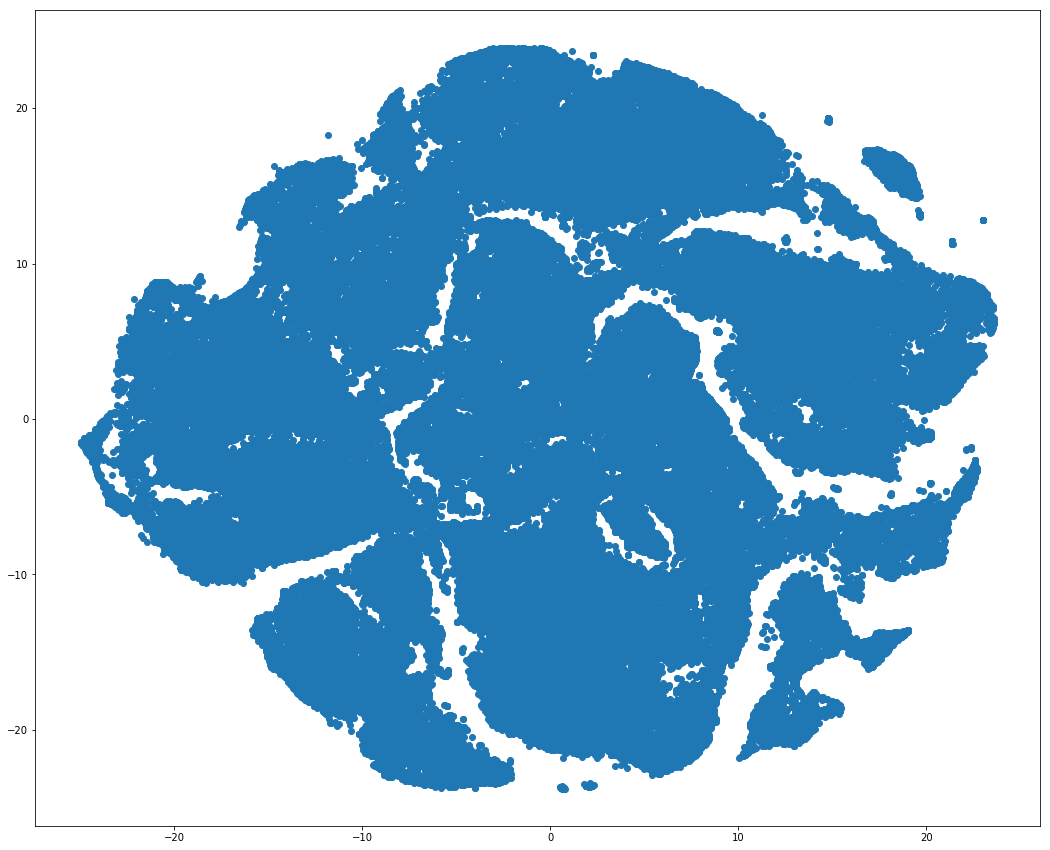

In [11]:
x = [v[0] for v in tsne_points]
y = [v[1] for v in tsne_points]

plt.scatter(x, y)
plt.show()

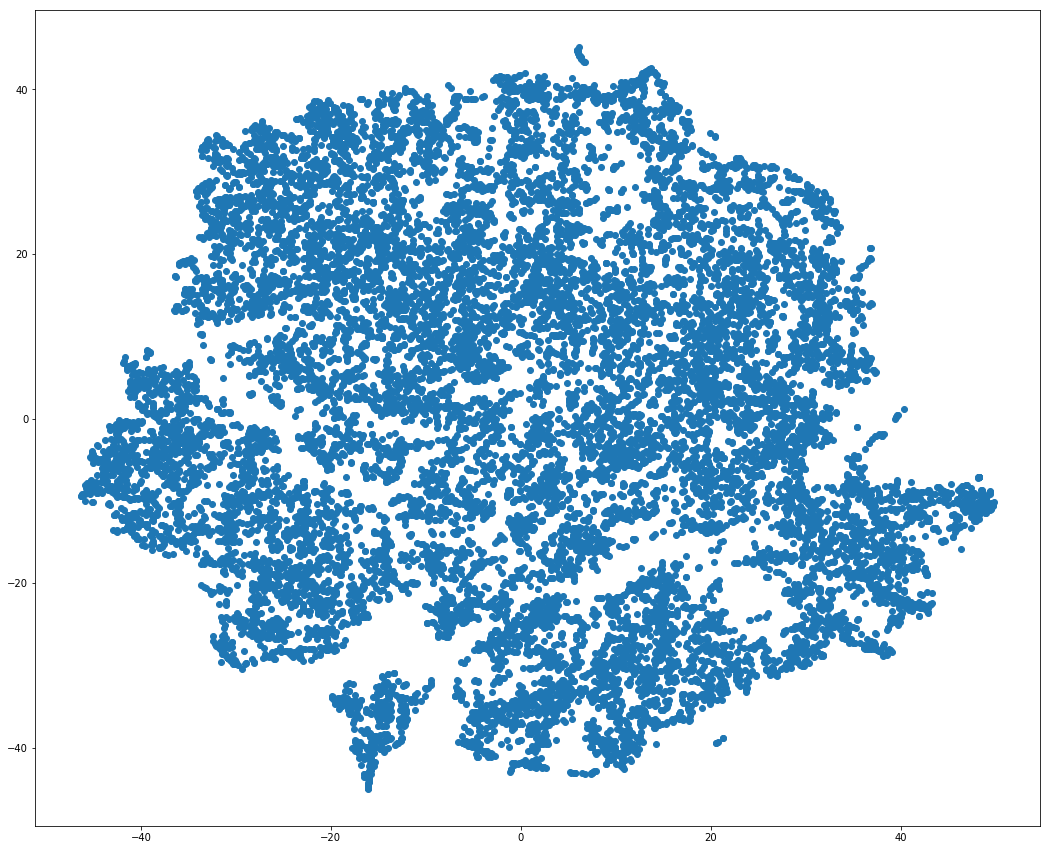

In [12]:
x = [v[0] for v in tsne_points]
y = [v[1] for v in tsne_points]

plt.scatter(x, y)
plt.show()